In [ ]:
# Load required libraries
library(fpp3)
library(tidyverse)       # Data manipulation and visualization
library(forecast)        # Forecasting methods
library(knitr)
#library(prophet)
library(lubridate)

options(repr.plot.width = 18, repr.plot.height = 7)

In [ ]:
# Load Data
calendar <- read.csv("data/calendar_afcs2024.csv")
prices <- read.csv("data/sell_prices_afcs2024.csv")
sales_train <- read.csv("data/sales_train_validation_afcs2024.csv")
sales_validation <- read.csv("data/sales_test_validation_afcs2024.csv")
sales_test <- read.csv("data/sales_test_evaluation_afcs2024.csv")

# Define the function
transform_and_clean_data <- function(sales_data, calendar_data, prices_data, start_date = "2011-01-29") {
  # Ensure the `date` column in calendar_data is of type
  calendar_data <- calendar_data %>%
    mutate(date = as.Date(date, format = "%m/%d/%Y"))


  # Convert sales data from wide to long format
  sales_long <- sales_data %>%
    pivot_longer(
      cols = starts_with("d_"),
      names_to = "day_id",
      values_to = "sales"
    ) %>%
    mutate(
      # Extract day number and compute the date
      day_num = as.integer(str_remove(day_id, "d_")),
      date = as.Date(start_date) + day_num
    ) %>%
    select(id, date, sales) # Keep relevant columns including `id`

  # Join with calendar data
  sales_with_calendar <- sales_long %>%
    left_join(calendar_data, by = "date")

  # Join with prices data
  cleaned_data <- sales_with_calendar %>%
    mutate(id_trimmed = str_extract(id, "^[^_]+_[^_]+_[^_]+")) %>% # We need to modify the id to match format from the sales dataset
    left_join(prices_data, by = c("id_trimmed" = "item_id", "wm_yr_wk"))

  return(cleaned_data)
}

# Checking if date works
# start_date <- as.Date("2011-01-29")
# calculated_date <- start_date + days(1913)
# print(calculated_date)

# Apply the function
cleaned_train_sales_data <- transform_and_clean_data(sales_train, calendar, prices, start_date = "2011-01-29")
head(cleaned_train_sales_data)
cleaned_train_sales_data$date <- as.Date(cleaned_train_sales_data$date)
most_recent_train_date <- max(cleaned_train_sales_data$date, na.rm = TRUE)
most_recent_train_date_string <- format(most_recent_train_date, "%Y-%m-%d")
print(most_recent_train_date_string)# Print the result


cleaned_validation_sales_data <- transform_and_clean_data(sales_validation, calendar, prices, start_date = most_recent_train_date_string)
head(cleaned_validation_sales_data)
most_recent_validation_date <- max(cleaned_validation_sales_data$date, na.rm = TRUE)
most_recent_validation_date_string <- format(most_recent_validation_date, "%Y-%m-%d")
print(most_recent_validation_date_string)



id,date,sales,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX,id_trimmed,store_id,sell_price
<chr>,<date>,<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
FOODS_3_001_TX_3_validation,2011-01-30,0,11101,Sunday,2,1,2011,NA,NA,NA,NA,0,FOODS_3_001,TX_3,2.28
FOODS_3_001_TX_3_validation,2011-01-31,2,11101,Monday,3,1,2011,NA,NA,NA,NA,0,FOODS_3_001,TX_3,2.28
FOODS_3_001_TX_3_validation,2011-02-01,1,11101,Tuesday,4,2,2011,NA,NA,NA,NA,1,FOODS_3_001,TX_3,2.28
FOODS_3_001_TX_3_validation,2011-02-02,3,11101,Wednesday,5,2,2011,NA,NA,NA,NA,0,FOODS_3_001,TX_3,2.28
FOODS_3_001_TX_3_validation,2011-02-03,0,11101,Thursday,6,2,2011,NA,NA,NA,NA,1,FOODS_3_001,TX_3,2.28
FOODS_3_001_TX_3_validation,2011-02-04,0,11101,Friday,7,2,2011,NA,NA,NA,NA,0,FOODS_3_001,TX_3,2.28


[1] "2016-04-25"


id,date,sales,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX,id_trimmed,store_id,sell_price
<chr>,<date>,<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
FOODS_3_001_TX_3_validation,2021-07-22,1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,FOODS_3_001,NA,NA
FOODS_3_001_TX_3_validation,2021-07-23,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,FOODS_3_001,NA,NA
FOODS_3_001_TX_3_validation,2021-07-24,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,FOODS_3_001,NA,NA
FOODS_3_001_TX_3_validation,2021-07-25,1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,FOODS_3_001,NA,NA
FOODS_3_001_TX_3_validation,2021-07-26,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,FOODS_3_001,NA,NA
FOODS_3_001_TX_3_validation,2021-07-27,1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,FOODS_3_001,NA,NA


[1] "2021-08-18"


## EDA


In [ ]:
# Set the values for top, middle, and bottom K products
top_k_products <- 10
middle_k_products <- 5
bottom_k_products <- 5

# Calculate total sales per product and select top, middle, and bottom products
product_sales_summary <- cleaned_train_sales_data %>%
  group_by(id_trimmed) %>%
  summarize(total_sales = sum(sales, na.rm = TRUE)) %>%
  arrange(desc(total_sales))

# Select top products
top_products <- product_sales_summary %>%
  slice_head(n = top_k_products)

# Select bottom products
bottom_products <- product_sales_summary %>%
  slice_tail(n = bottom_k_products)

# Select middle products
middle_start <- max(1, (nrow(product_sales_summary) - middle_k_products) %/% 2)
middle_products <- product_sales_summary %>%
  slice(middle_start:(middle_start + middle_k_products - 1))

# Combine top, middle, and bottom products and filter the data
selected_products <- bind_rows(top_products, middle_products, bottom_products)
filtered_data <- cleaned_train_sales_data %>%
  filter(id_trimmed %in% selected_products$id_trimmed)

# Ensure `id_trimmed` is ordered for plots
filtered_data$id_trimmed <- factor(
  filtered_data$id_trimmed,
  levels = selected_products$id_trimmed
)

# Inspect middle products
head(middle_products)

# Create the directory to save plots
if (!dir.exists("r_plots")) {
  dir.create("r_plots")
}

### TABLES ###

# 1. Summary Statistics for Selected Products
selected_products_stats <- filtered_data %>%
  group_by(id_trimmed) %>%
  summarize(
    mean_sales = mean(sales, na.rm = TRUE),
    median_sales = median(sales, na.rm = TRUE),
    sd_sales = sd(sales, na.rm = TRUE),
    total_sales = sum(sales, na.rm = TRUE),
    max_sales = max(sales, na.rm = TRUE),
    min_sales = min(sales, na.rm = TRUE),
    n_days = n()  # Number of days observed
  ) %>%
  arrange(desc(total_sales))

kable(
  selected_products_stats,
  format = "latex",
  booktabs = TRUE,
  caption = "Summary Statistics for Top 10, Middle 5, and Bottom 5 Products"
)

# 2. Proportion of Zero Sales
zero_sales_stats <- filtered_data %>%
  group_by(id_trimmed) %>%
  summarize(
    total_days = n(),
    zero_sales_days = sum(sales == 0, na.rm = TRUE),
    zero_sales_pct = (zero_sales_days / total_days) * 100
  ) %>%
  arrange(desc(zero_sales_pct))

kable(
  zero_sales_stats,
  format = "latex",
  booktabs = TRUE,
  caption = "Proportion of Zero Sales for Top 10, Middle 5, and Bottom 5 Products"
)

# 3. Price Statistics for Selected Products
price_stats <- filtered_data %>%
  group_by(id_trimmed) %>%
  summarize(
    mean_price = mean(sell_price, na.rm = TRUE),
    median_price = median(sell_price, na.rm = TRUE),
    sd_price = sd(sell_price, na.rm = TRUE),
    min_price = min(sell_price, na.rm = TRUE),
    max_price = max(sell_price, na.rm = TRUE)
  ) %>%
  arrange(desc(mean_price))

kable(
  price_stats,
  format = "latex",
  booktabs = TRUE,
  caption = "Price Statistics for Top 10, Middle 5, and Bottom 5 Products"
)

# 4. Correlation Between Sales and Prices
# Correlation Between Sales and Prices
filtered_data_nonconstant <- filtered_data %>%
  group_by(id_trimmed) %>%
  filter(sd(sales, na.rm = TRUE) > 1e-5, sd(sell_price, na.rm = TRUE) > 1e-5)

sales_price_corr <- filtered_data_nonconstant %>%
  group_by(id_trimmed) %>%
  summarize(
    correlation = cor(sales, sell_price, use = "pairwise.complete.obs")
  ) %>%
  mutate(across(where(is.numeric), round, 2)) %>%
  arrange(desc(correlation))

kable(
  sales_price_corr,
  format = "latex",
  booktabs = TRUE,
  caption = "Correlation Between Sales and Prices for Top 10, Middle 5, and Bottom 5 Products"
)

### PLOTS ###

# Plot 1: Sales trends for selected products
sales_trends_plot <- ggplot(filtered_data, aes(x = date, y = sales, color = id_trimmed)) +
  geom_line() +
  facet_wrap(~id_trimmed, scales = "free_y") +
  labs(
    title = sprintf("Sales Trends for Top (%s), Middle (%s), and Bottom (%s) Products", top_k_products, middle_k_products, bottom_k_products),
    x = "Date",
    y = "Sales",
    color = "Product ID"
  ) +
  theme_minimal()

ggsave(
  filename = sprintf("r_plots/sales_trends_top_%s_middle_%s_bottom_%s.png", top_k_products, middle_k_products, bottom_k_products),
  plot = sales_trends_plot,
  width = 10,
  height = 6,
  dpi = 300
)

# Plot 2: Sales distribution
sales_distribution_plot <- ggplot(filtered_data, aes(x = sales, fill = id_trimmed)) +
  geom_density(alpha = 0.5) +
  facet_wrap(~id_trimmed, scales = "free") +
  labs(
    title = sprintf("Sales Distribution for Top (%s), Middle (%s), and Bottom (%s) Products", top_k_products, middle_k_products, bottom_k_products),
    x = "Sales",
    y = "Density",
    fill = "Product ID"
  ) +
  theme_minimal()

ggsave(
  filename = sprintf("r_plots/sales_distribution_top_%s_middle_%s_bottom_%s.png", top_k_products, middle_k_products, bottom_k_products),
  plot = sales_distribution_plot,
  width = 10,
  height = 6,
  dpi = 300
)

# STL Decomposition for Top K Only
filtered_top_data <- filtered_data %>%
  filter(id_trimmed %in% top_products$id_trimmed)

top_products_tsibble <- filtered_top_data %>%
  as_tsibble(index = date, key = id_trimmed)

stl_decomposition_plot <- top_products_tsibble %>%
  model(STL(sales ~ season(window = "periodic"))) %>%
  components() %>%
  autoplot() +
  labs(
    title = sprintf("Seasonal Decomposition of Top (%s) Products", top_k_products),
    x = "Date",
    y = "Sales"
  )

ggsave(
  filename = sprintf("r_plots/stl_decomposition_top_%s.png", top_k_products),
  plot = stl_decomposition_plot,
  width = 10,
  height = 6,
  dpi = 300
)

# Plot 3: Aggregated sales trends
aggregated_sales_trends <- filtered_data %>%
  group_by(date, id_trimmed) %>%
  summarize(total_sales = sum(sales, na.rm = TRUE))

aggregated_sales_trends_plot <- ggplot(aggregated_sales_trends, aes(x = date, y = total_sales, color = id_trimmed)) +
  geom_line() +
  labs(
    title = sprintf("Aggregated Sales Trends for Top (%s), Middle (%s), and Bottom (%s) Products", top_k_products, middle_k_products, bottom_k_products),
    x = "Date",
    y = "Total Sales",
    color = "Product ID"
  ) +
  theme_minimal()

ggsave(
  filename = sprintf("r_plots/aggregated_sales_trends_top_%s_middle_%s_bottom_%s.png", top_k_products, middle_k_products, bottom_k_products),
  plot = aggregated_sales_trends_plot,
  width = 10,
  height = 6,
  dpi = 300
)

# Plot 4: Sales histogram
sales_histogram_plot <- ggplot(filtered_data, aes(x = sales)) +
  geom_histogram(binwidth = 1, fill = "blue", alpha = 0.7) +
  labs(
    title = sprintf("Sales Histogram for Top (%s), Middle (%s), and Bottom (%s) Products", top_k_products, middle_k_products, bottom_k_products),
    x = "Sales",
    y = "Frequency"
  ) +
  theme_minimal()

ggsave(
  filename = sprintf("r_plots/sales_histogram_top_%s_middle_%s_bottom_%s.png", top_k_products, middle_k_products, bottom_k_products),
  plot = sales_histogram_plot,
  width = 10,
  height = 6,
  dpi = 300
)

id_trimmed,total_sales
<chr>,<int>
FOODS_3_721,1257
FOODS_3_725,1256
FOODS_3_731,1256
FOODS_3_760,1256
FOODS_3_464,1253


\begin{table}

\caption{Summary Statistics for Top 10, Middle 5, and Bottom 5 Products}
\centering
\begin{tabular}[t]{lrrrrrrr}
\toprule
id\_trimmed & mean\_sales & median\_sales & sd\_sales & total\_sales & max\_sales & min\_sales & n\_days\\
\midrule
FOODS\_3\_586 & 78.4746472 & 76 & 25.1578596 & 150122 & 200 & 0 & 1913\\
FOODS\_3\_090 & 60.0386827 & 61 & 48.1017333 & 114854 & 380 & 0 & 1913\\
FOODS\_3\_252 & 45.2859383 & 43 & 20.5680648 & 86632 & 150 & 0 & 1913\\
FOODS\_3\_555 & 40.6027182 & 37 & 18.7406611 & 77673 & 128 & 0 & 1913\\
FOODS\_3\_377 & 38.5765813 & 38 & 11.7613790 & 73797 & 95 & 0 & 1913\\
\addlinespace
FOODS\_3\_030 & 25.0789336 & 21 & 28.0731736 & 47976 & 320 & 0 & 1913\\
FOODS\_3\_202 & 21.7203346 & 21 & 13.8662050 & 41551 & 109 & 0 & 1913\\
FOODS\_3\_714 & 21.2493466 & 20 & 10.2692839 & 40650 & 88 & 0 & 1913\\
FOODS\_3\_587 & 21.0695243 & 21 & 14.6503844 & 40306 & 83 & 0 & 1913\\
FOODS\_3\_694 & 18.3753267 & 18 & 6.9953106 & 35152 & 54 & 0 & 1913\\
\addlinespace
FO

\begin{table}

\caption{Proportion of Zero Sales for Top 10, Middle 5, and Bottom 5 Products}
\centering
\begin{tabular}[t]{lrrr}
\toprule
id\_trimmed & total\_days & zero\_sales\_days & zero\_sales\_pct\\
\midrule
FOODS\_3\_260 & 1913 & 1883 & 98.4317825\\
FOODS\_3\_171 & 1913 & 1883 & 98.4317825\\
FOODS\_3\_472 & 1913 & 1877 & 98.1181390\\
FOODS\_3\_693 & 1913 & 1871 & 97.8044956\\
FOODS\_3\_633 & 1913 & 1857 & 97.0726607\\
\addlinespace
FOODS\_3\_760 & 1913 & 1537 & 80.3450078\\
FOODS\_3\_731 & 1913 & 1236 & 64.6105593\\
FOODS\_3\_721 & 1913 & 1172 & 61.2650288\\
FOODS\_3\_725 & 1913 & 1166 & 60.9513853\\
FOODS\_3\_464 & 1913 & 1136 & 59.3831678\\
\addlinespace
FOODS\_3\_090 & 1913 & 472 & 24.6732880\\
FOODS\_3\_030 & 1913 & 467 & 24.4119185\\
FOODS\_3\_587 & 1913 & 388 & 20.2822791\\
FOODS\_3\_202 & 1913 & 257 & 13.4343962\\
FOODS\_3\_555 & 1913 & 9 & 0.4704652\\
\addlinespace
FOODS\_3\_377 & 1913 & 8 & 0.4181913\\
FOODS\_3\_714 & 1913 & 8 & 0.4181913\\
FOODS\_3\_694 & 1913 & 8 & 0

\begin{table}

\caption{Price Statistics for Top 10, Middle 5, and Bottom 5 Products}
\centering
\begin{tabular}[t]{lrrrrr}
\toprule
id\_trimmed & mean\_price & median\_price & sd\_price & min\_price & max\_price\\
\midrule
FOODS\_3\_202 & 4.202227 & 4.28 & 0.3276735 & 2.40 & 4.48\\
FOODS\_3\_693 & 3.480000 & 3.48 & 0.0000000 & 3.48 & 3.48\\
FOODS\_3\_464 & 3.475140 & 3.48 & 0.2074400 & 2.98 & 3.68\\
FOODS\_3\_731 & 2.980000 & 2.98 & 0.0000000 & 2.98 & 2.98\\
FOODS\_3\_633 & 2.880000 & 2.88 & 0.0000000 & 2.88 & 2.88\\
\addlinespace
FOODS\_3\_760 & 2.853164 & 2.88 & 0.2238324 & 0.99 & 2.88\\
FOODS\_3\_725 & 2.815602 & 2.88 & 0.1689472 & 1.66 & 2.88\\
FOODS\_3\_587 & 2.518526 & 2.68 & 0.2464620 & 1.87 & 2.68\\
FOODS\_3\_171 & 2.464679 & 2.48 & 0.1097219 & 1.68 & 2.48\\
FOODS\_3\_472 & 1.970000 & 1.97 & 0.0000000 & 1.97 & 1.97\\
\addlinespace
FOODS\_3\_260 & 1.970000 & 1.97 & 0.0000000 & 1.97 & 1.97\\
FOODS\_3\_721 & 1.894668 & 1.98 & 0.1072264 & 1.76 & 1.98\\
FOODS\_3\_694 & 1.603628 & 1

Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `across(where(is.numeric), round, 2)`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))"


\begin{table}

\caption{Correlation Between Sales and Prices for Top 10, Middle 5, and Bottom 5 Products}
\centering
\begin{tabular}[t]{lr}
\toprule
id\_trimmed & correlation\\
\midrule
FOODS\_3\_464 & 0.16\\
FOODS\_3\_377 & 0.11\\
FOODS\_3\_760 & 0.11\\
FOODS\_3\_202 & 0.05\\
FOODS\_3\_714 & 0.05\\
\addlinespace
FOODS\_3\_252 & 0.00\\
FOODS\_3\_171 & -0.01\\
FOODS\_3\_725 & -0.05\\
FOODS\_3\_721 & -0.11\\
FOODS\_3\_090 & -0.12\\
\addlinespace
FOODS\_3\_694 & -0.18\\
FOODS\_3\_586 & -0.32\\
FOODS\_3\_587 & -0.38\\
FOODS\_3\_030 & -0.47\\
FOODS\_3\_555 & -0.52\\
\bottomrule
\end{tabular}
\end{table}

`summarise()` has grouped output by 'date'. You can override using the
`.groups` argument.


In [ ]:
filtered_metrics <- read.csv("filtered_metrics.csv")
kable(
  filtered_metrics,
  format = "latex",
  booktabs = TRUE,
  caption = "Result: Top 20 Products with Highest Sales"
)


\begin{table}

\caption{Result: Top 20 Products with Highest Sales}
\centering
\begin{tabular}[t]{lrrrr}
\toprule
Product.ID & MAE & RMSE & Test\_Weekly\_Average\_Sales & Test\_Total\_Sales\\
\midrule
FOODS\_3\_030\_TX\_3\_validation & 12.32 & 15.16 & 23 & 641\\
FOODS\_3\_080\_TX\_3\_validation & 3.14 & 3.97 & 11 & 305\\
FOODS\_3\_090\_TX\_3\_validation & 25.61 & 29.35 & 64 & 1799\\
FOODS\_3\_202\_TX\_3\_validation & 8.39 & 9.94 & 32 & 892\\
FOODS\_3\_252\_TX\_3\_validation & 15.68 & 19.66 & 51 & 1440\\
\addlinespace
FOODS\_3\_376\_TX\_3\_validation & 8.46 & 10.50 & 15 & 426\\
FOODS\_3\_377\_TX\_3\_validation & 8.07 & 10.27 & 42 & 1168\\
FOODS\_3\_541\_TX\_3\_validation & 10.36 & 11.40 & 7 & 190\\
FOODS\_3\_555\_TX\_3\_validation & 9.50 & 11.66 & 30 & 829\\
FOODS\_3\_586\_TX\_3\_validation & 13.96 & 16.25 & 73 & 2056\\
\addlinespace
FOODS\_3\_587\_TX\_3\_validation & 9.68 & 11.55 & 23 & 636\\
FOODS\_3\_607\_TX\_3\_validation & 7.71 & 10.36 & 14 & 385\\
FOODS\_3\_635\_TX\_3\_validation 

### Statistics


In [ ]:
# Monthly sales aggregation
monthly_sales <- filtered_data %>%
  mutate(month = month(date, label = TRUE)) %>%
  group_by(id_trimmed, month) %>%
  summarize(total_sales = sum(sales, na.rm = TRUE)) %>%
  arrange(desc(total_sales))

# Display the table
# kable(monthly_sales, caption = sprintf("Monthly Sales for Top (%s) Products", top_k_products))


# Weekday sales aggregation
weekday_sales <- filtered_data %>%
  mutate(weekday = wday(date, label = TRUE)) %>%
  group_by(id_trimmed, weekday) %>%
  summarize(total_sales = sum(sales, na.rm = TRUE)) %>%
  arrange(desc(total_sales))

# Display the table
# kable(weekday_sales, caption = sprintf("Sales by Day of the Week for Top (%s) Products", top_k_products))


# Sales during events
event_sales <- filtered_data %>%
  filter(!is.na(event_name_1)) %>%
  group_by(id_trimmed, event_name_1) %>%
  summarize(
    total_sales = sum(sales, na.rm = TRUE),
    mean_sales = mean(sales, na.rm = TRUE)
  ) %>%
  arrange(desc(total_sales))

# Display the table
# kable(event_sales, caption = sprintf("Event-Based Sales for Top (%s) Products", top_k_products))

`summarise()` has grouped output by 'id_trimmed'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'id_trimmed'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'id_trimmed'. You can override using the
`.groups` argument.


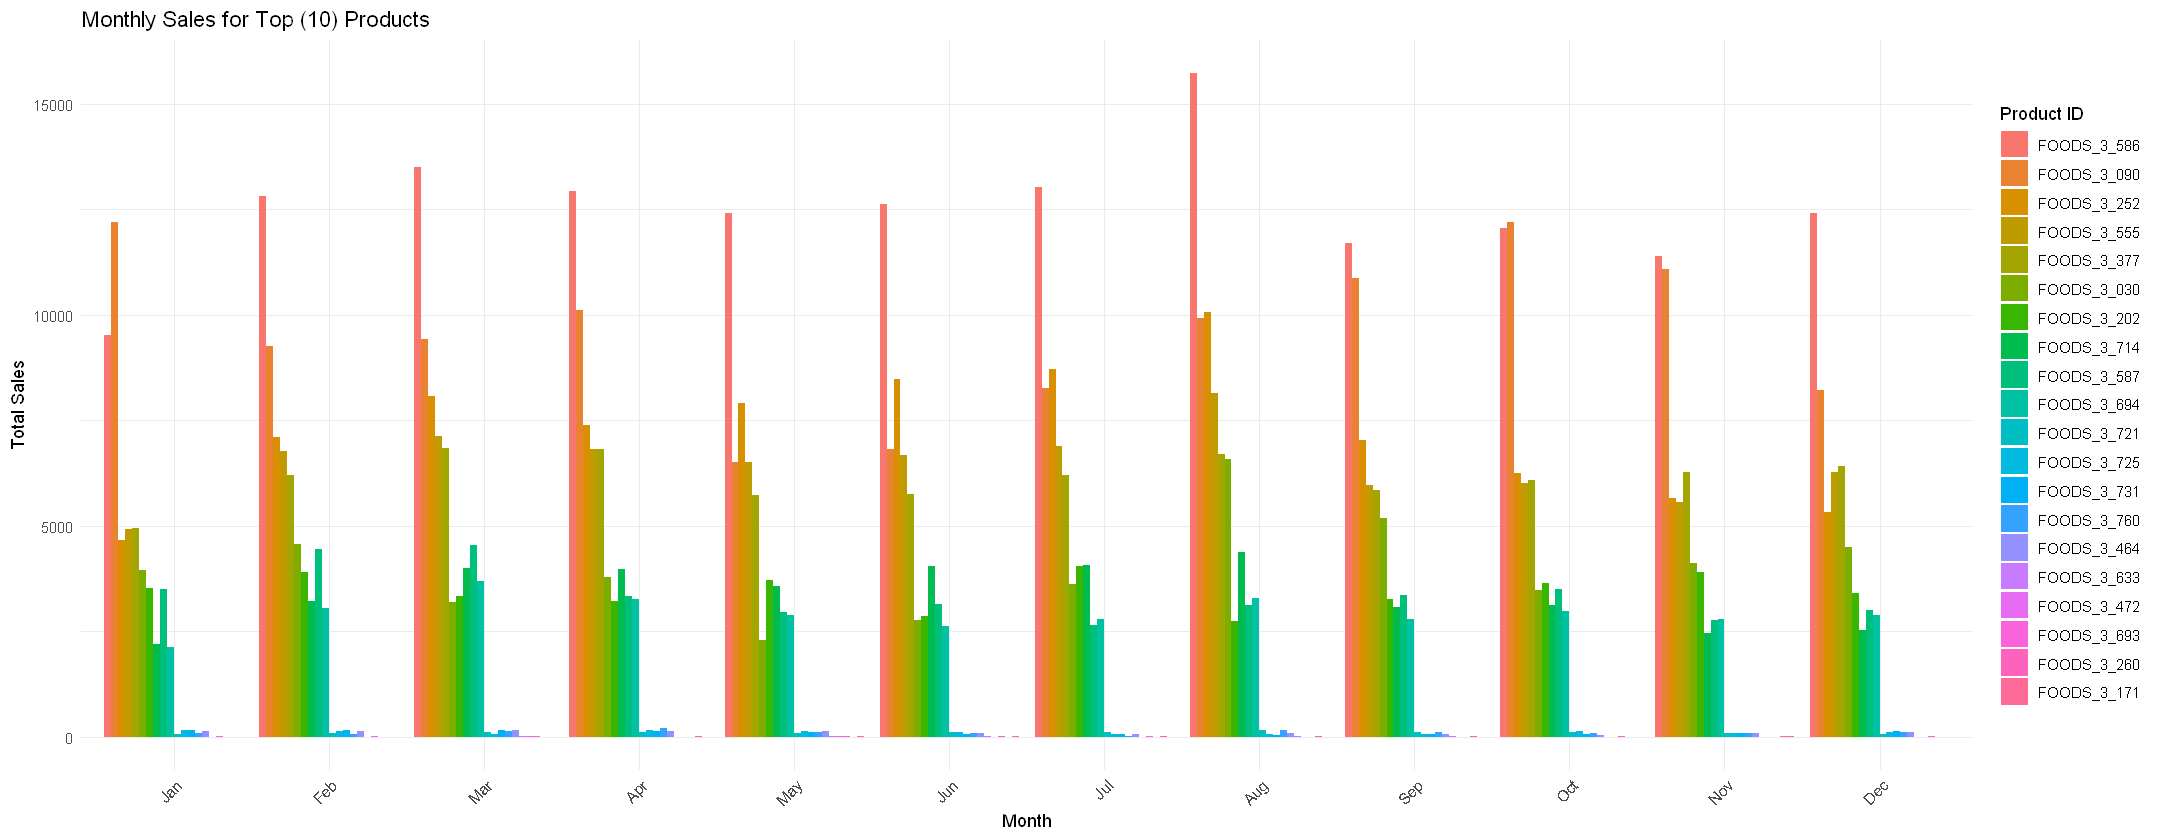

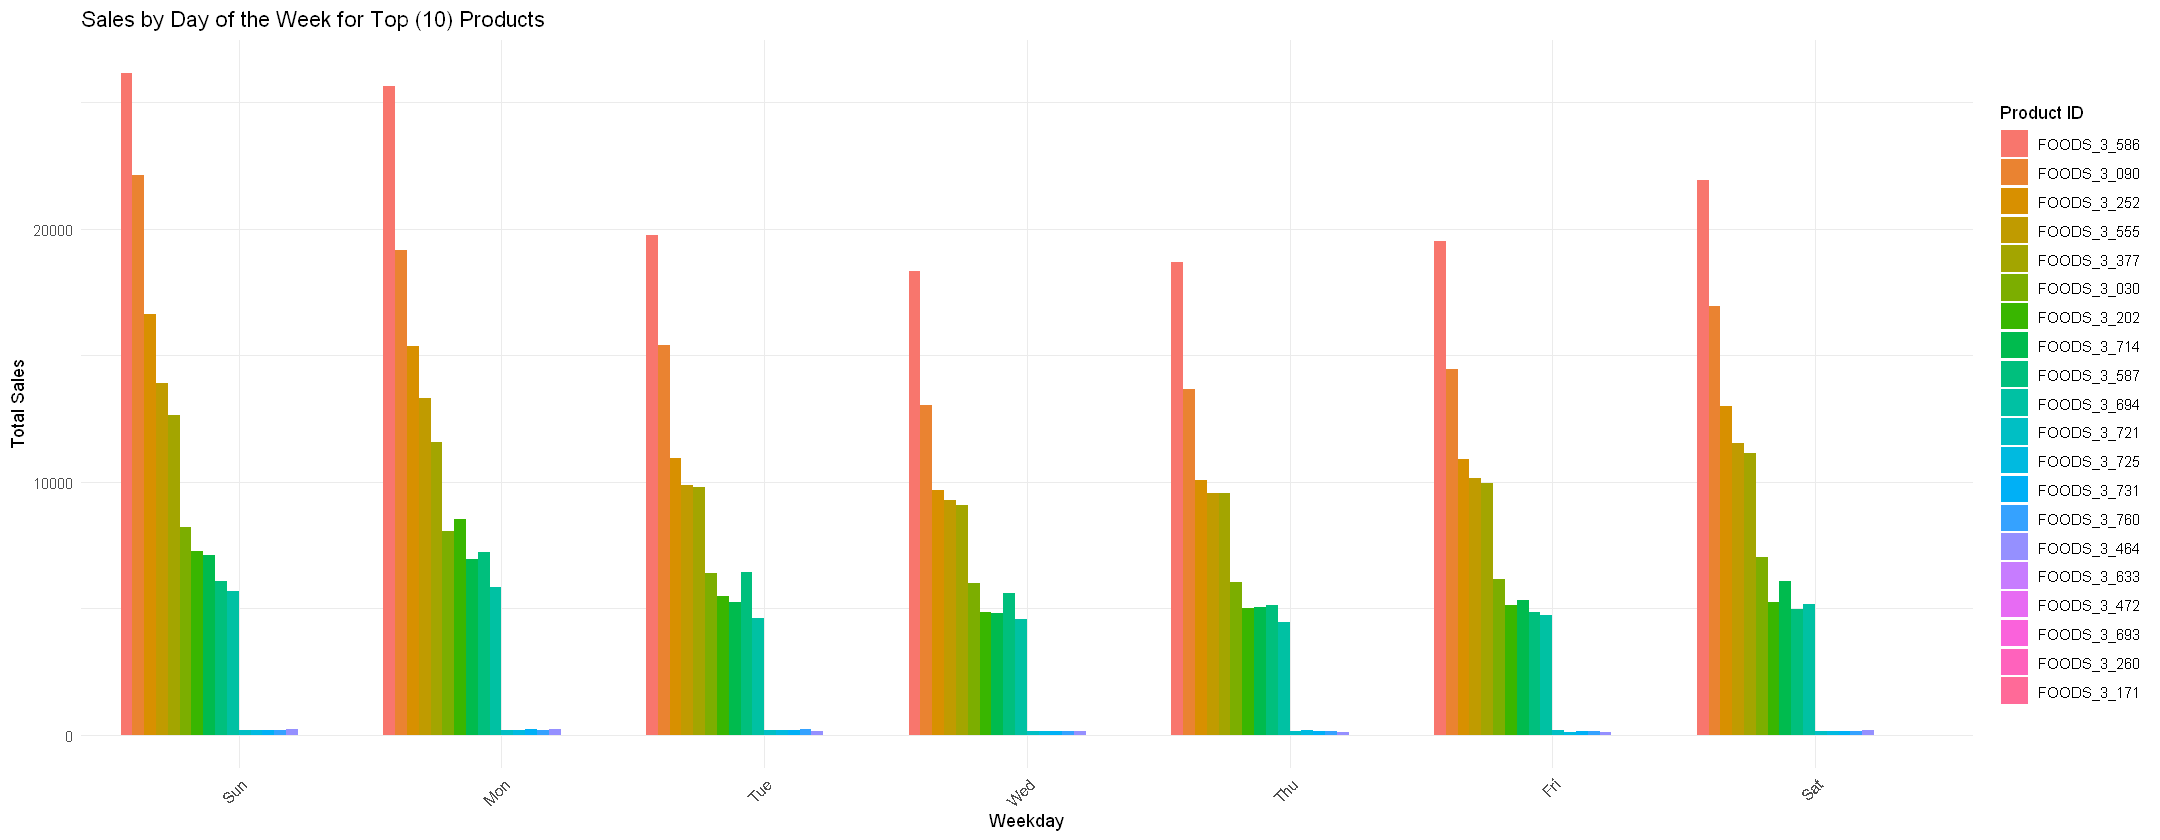

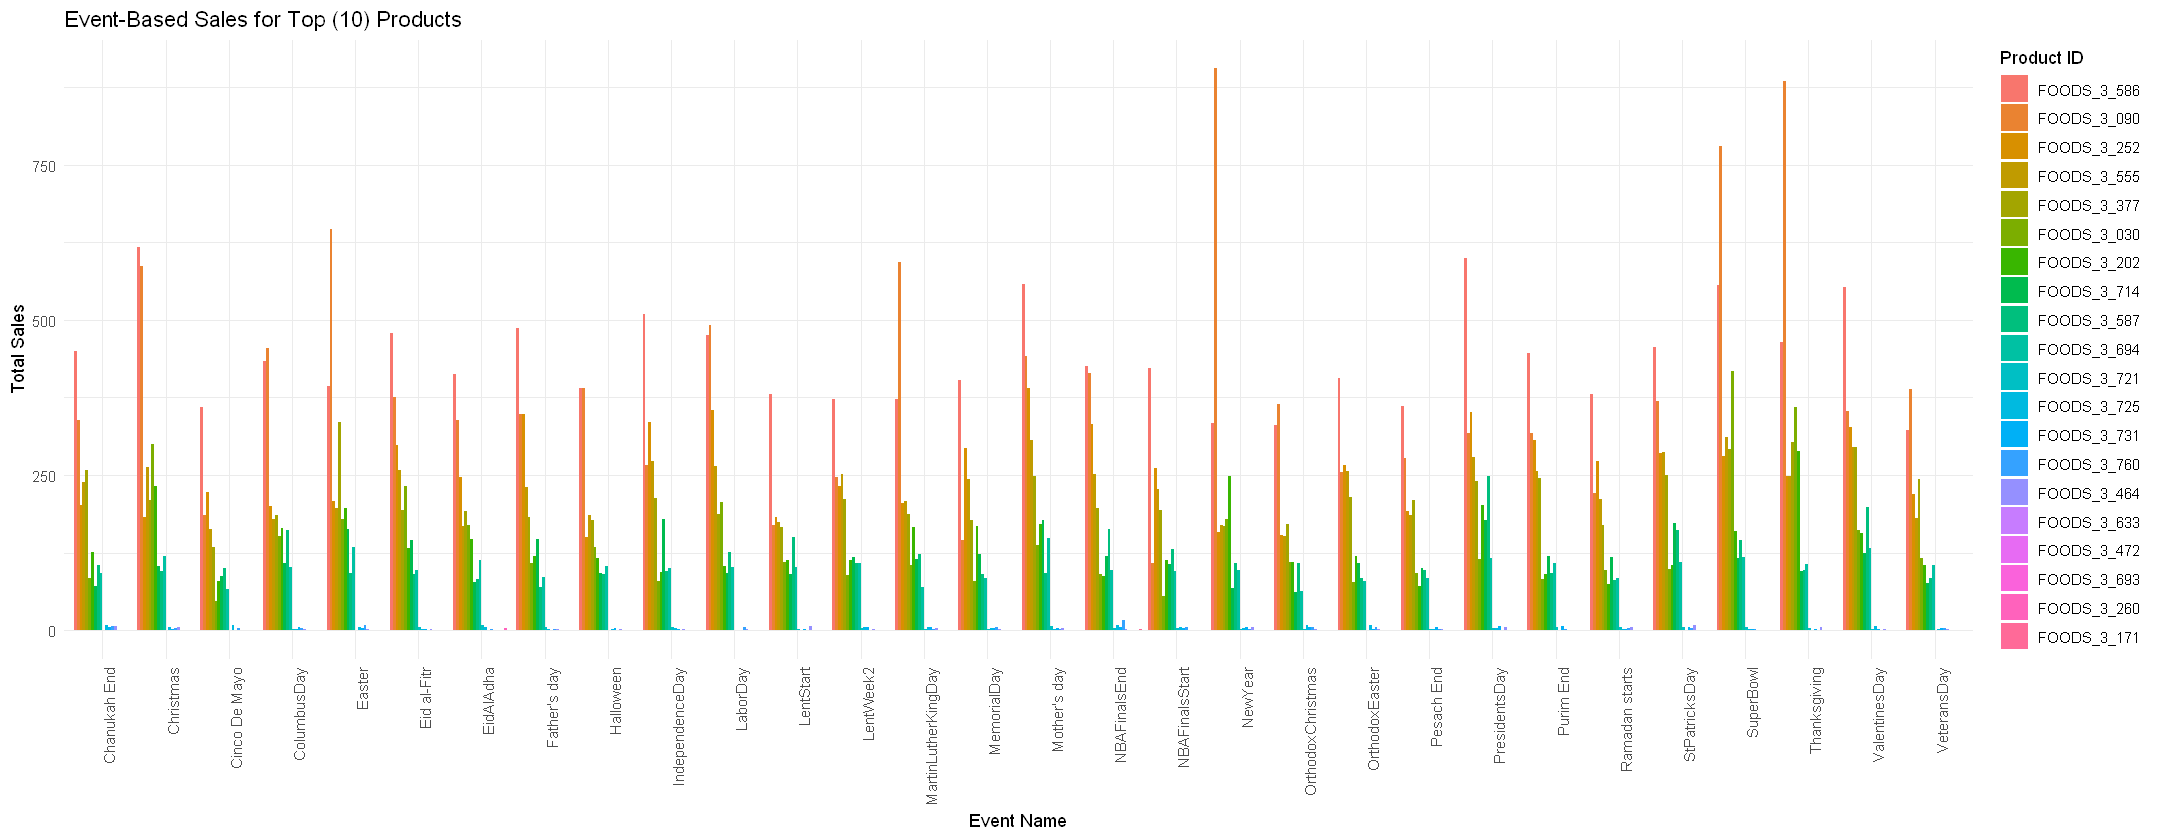

In [ ]:
# Monthly Sales Plot
monthly_sales <- monthly_sales %>%
  mutate(month = factor(month, levels = c("Jan", "Feb", "Mar", "Apr", "May", "Jun",
                                          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec")))

ggplot(monthly_sales, aes(x = month, y = total_sales, fill = id_trimmed)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(
    title = sprintf("Monthly Sales for Top (%s) Products", top_k_products),
    x = "Month",
    y = "Total Sales",
    fill = "Product ID"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Weekday Sales Plot
weekday_sales <- weekday_sales %>%
  mutate(weekday = factor(weekday, levels = c("Sun", "Mon", "Tue",
                                              "Wed", "Thu", "Fri", "Sat")))

ggplot(weekday_sales, aes(x = weekday, y = total_sales, fill = id_trimmed)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(
    title = sprintf("Sales by Day of the Week for Top (%s) Products", top_k_products),
    x = "Weekday",
    y = "Total Sales",
    fill = "Product ID"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Event-Based Sales Plot
if (nrow(event_sales) > 0) {
  ggplot(event_sales, aes(x = event_name_1, y = total_sales, fill = id_trimmed)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(
      title = sprintf("Event-Based Sales for Top (%s) Products", top_k_products),
      x = "Event Name",
      y = "Total Sales",
      fill = "Product ID"
    ) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))
} else {
  cat("No event-based sales data available.")
}

## Modelling


In [ ]:
FOODS_3_586_train <- cleaned_train_sales_data %>%
    filter(id_trimmed == "FOODS_3_586") %>%
    rename(ds = date, y = sales) %>%
    select(ds, y)
head(FOODS_3_586_train)

FOODS_3_586_validate <- cleaned_validation_sales_data %>%
    filter(id_trimmed == "FOODS_3_586") %>%
    rename(ds = date, y = sales) %>%
    select(ds, y)
head(FOODS_3_586_validate)

ds,y
<date>,<int>
2011-01-30,115
2011-01-31,116
2011-02-01,71
2011-02-02,66
2011-02-03,66
2011-02-04,89


ds,y
<date>,<int>
2021-07-22,58
2021-07-23,47
2021-07-24,58
2021-07-25,31
2021-07-26,66
2021-07-27,65


### Classical


Warning message in ets(ts_data):
"I can't handle data with frequency greater than 24. Seasonality will be ignored. Try stlf() if you need seasonal forecasts."
Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
Warning message in geom_line(color = "blue", size = 1, linetype = "solid", aes(label = "Train Data")):
"Ignoring unknown aesthetics: label"
Warning message in geom_line(data = test_df, aes(x = date, y = sales), color = "red", :
"Ignoring unknown parameters: `label`"



--- Model Evaluation Metrics ---

 STL_ETS Model Accuracy:
                ME     RMSE      MAE       MPE     MAPE
Test set -6.345761 21.49489 18.63271 -21.18963 35.54322

 ETS Model Accuracy:
               ME    RMSE      MAE       MPE     MAPE
Test set 4.470502 18.1728 14.66504 -1.700683 25.30321

 ARIMA Model Accuracy:
               ME     RMSE     MAE      MPE     MAPE
Test set 6.634473 18.78972 15.0853 2.141684 25.09454

 ARIMA_Fourier Model Accuracy:
               ME   RMSE      MAE       MPE     MAPE
Test set 2.362014 17.476 14.14896 -5.302502 25.50887


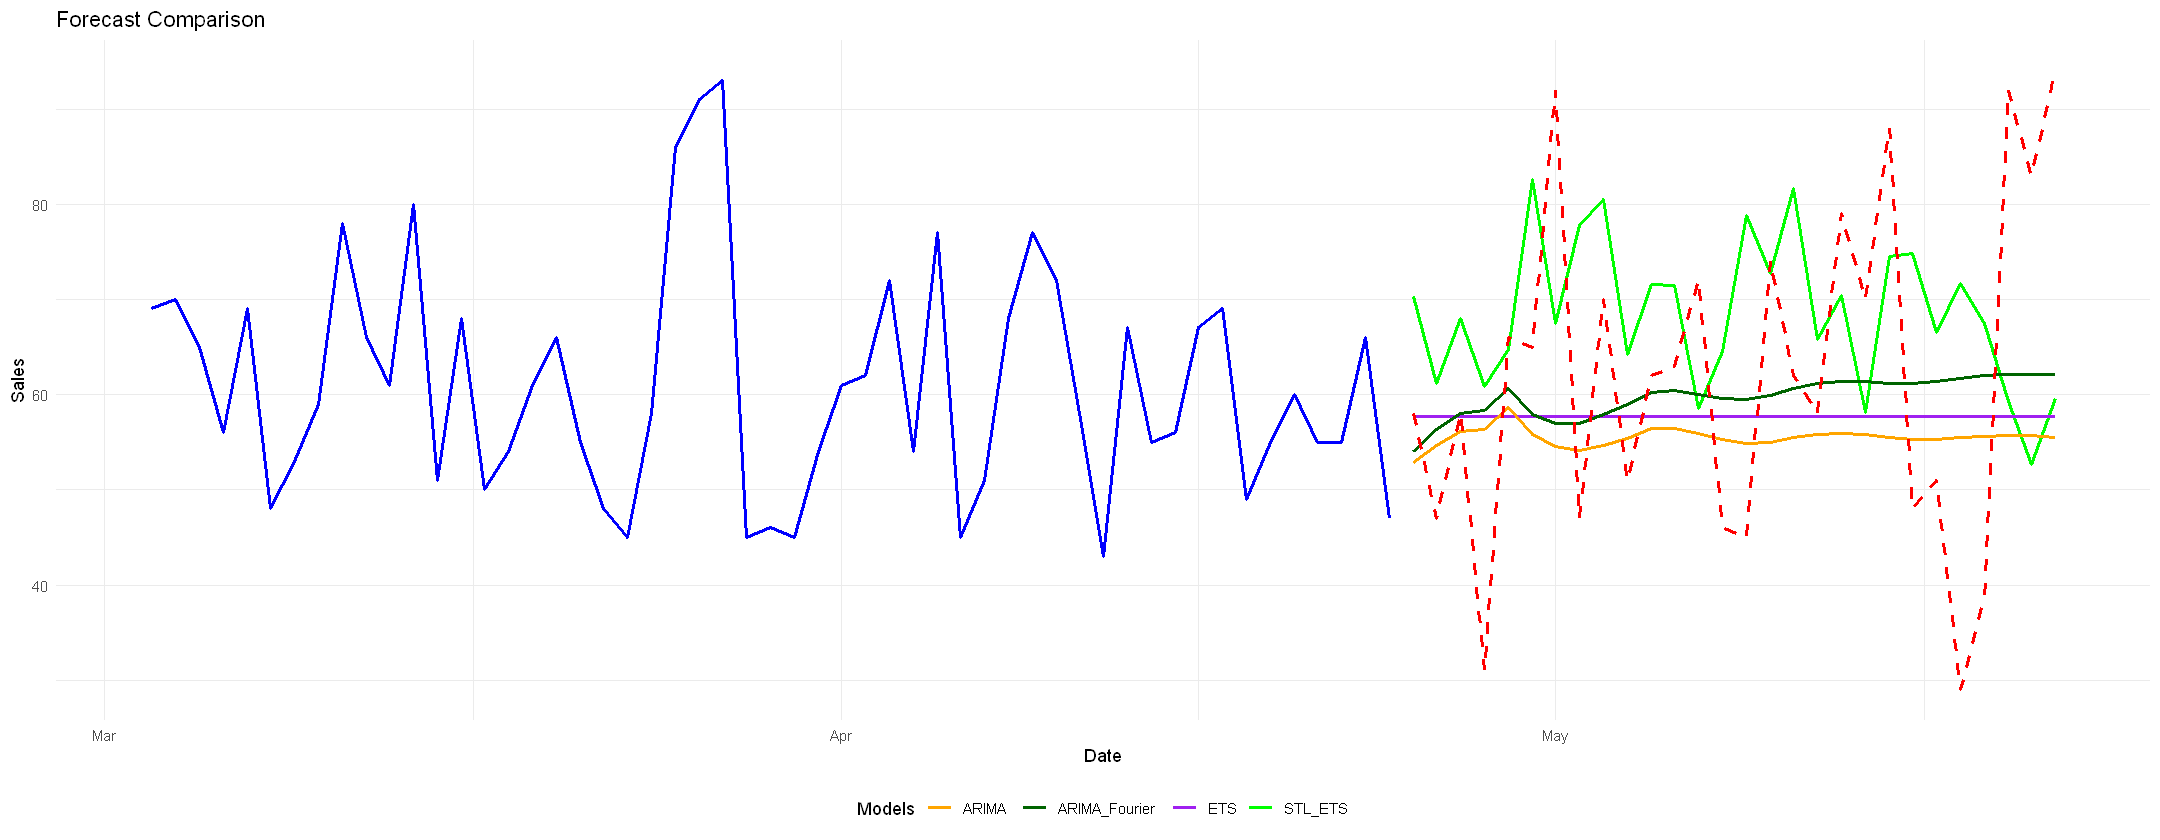

In [ ]:
# Function to prepare data for modeling
prepare_data <- function(data, id_value, start_date) {
  ts_data <- data %>%
    filter(id_trimmed == id_value) %>%
    select(date, sales)

  # Convert to time series object
  start_year <- as.numeric(format(as.Date(start_date), "%Y"))
  start_day <- as.numeric(format(as.Date(start_date), "%j"))

  ts_obj <- ts(ts_data$sales, frequency = 365, start = c(start_year, start_day))
  return(ts_obj)
}

# Forecasting Methods
stl_ets_forecast <- function(ts_data, h) stlf(ts_data, method = "ets", h = h)
ets_forecast <- function(ts_data, h) forecast(ets(ts_data), h = h)
arima_forecast <- function(ts_data, h) forecast(auto.arima(ts_data), h = h)

arima_fourier_forecast <- function(ts_data, h, K) {
  fourier_terms <- fourier(ts_data, K)
  arima_fit <- auto.arima(ts_data, xreg = fourier_terms)
  future_fourier_terms <- fourier(ts_data, K, h)
  forecast(arima_fit, xreg = future_fourier_terms, h = h)
}

# Function to evaluate forecasts
evaluate_forecasts <- function(forecasts, test_data) {
  cat("\n--- Model Evaluation Metrics ---\n")
  for (name in names(forecasts)) {
    fc_values <- as.numeric(forecasts[[name]]$mean) # Ensure numeric alignment
    test_values <- as.numeric(test_data[1:length(fc_values)]) # Match lengths
    accuracy_metrics <- accuracy(fc_values, test_values)
    cat(paste("\n", name, "Model Accuracy:\n"))
    print(accuracy_metrics)
  }
}

plot_forecasts <- function(forecasts, ts_train, ts_test = NULL, h = 28, history_window = 52, start_date = "2011-01-29") {
  # Subset recent history window
  plot_start <- max(1, length(ts_train) - history_window) # Recent history window
  ts_train_recent <- window(ts_train, start = time(ts_train)[plot_start])

  # Convert training data to a data frame for ggplot compatibility
  train_df <- data.frame(
    date = seq(as.Date(start_date) + (plot_start - 1), by = "day", length.out = length(ts_train_recent)),
    sales = as.numeric(ts_train_recent)
  )

  # Create a base ggplot with the recent training data
  p <- ggplot(train_df, aes(x = date, y = sales)) +
    geom_line(color = "blue", size = 1, linetype = "solid", aes(label = "Train Data")) +
    labs(title = "Forecast Comparison", x = "Date", y = "Sales") +
    theme_minimal()

  # Add forecasts and test data
  for (name in names(forecasts)) {
    fc <- forecasts[[name]]$mean
    forecast_dates <- seq(as.Date(start_date) + length(ts_train), by = "day", length.out = h)

    fc_df <- data.frame(
      date = forecast_dates,
      sales = as.numeric(fc),
      model = name
    )
    p <- p + geom_line(data = fc_df, aes(x = date, y = sales, color = model), size = 1)
  }

  # Add test data if available
  if (!is.null(ts_test)) {
    test_dates <- seq(as.Date(start_date) + length(ts_train), by = "day", length.out = h)
    test_df <- data.frame(
      date = test_dates,
      sales = as.numeric(ts_test)
    )
    p <- p + geom_line(data = test_df, aes(x = date, y = sales), color = "red", linetype = "dashed", size = 1, label = "Test Data")
  }

  # Add a legend
  p <- p + scale_color_manual(values = c("STL_ETS" = "green", "ETS" = "purple", "ARIMA" = "orange", "ARIMA_Fourier" = "darkgreen")) +
    guides(color = guide_legend(title = "Models")) +
    theme(legend.position = "bottom")

  print(p)
}

# Unified Forecasting Pipeline
forecast_pipeline <- function(ts_train, ts_test = NULL, h = 28, K = 4) {
  stl_ets_fc <- stl_ets_forecast(ts_train, h)
  ets_fc <- ets_forecast(ts_train, h)
  arima_fc <- arima_forecast(ts_train, h)
  arima_fourier_fc <- arima_fourier_forecast(ts_train, h, K)

  forecasts <- list(
    STL_ETS = stl_ets_fc,
    ETS = ets_fc,
    ARIMA = arima_fc,
    ARIMA_Fourier = arima_fourier_fc
  )

  plot_forecasts(forecasts, ts_train, ts_test)
  if (!is.null(ts_test)) evaluate_forecasts(forecasts, ts_test)
}

# ============================
# Main Script Execution
# ============================
# # Prepare train and test data
FOODS_3_586_train <- prepare_data(cleaned_train_sales_data, "FOODS_3_586", "2011-01-29")
FOODS_3_586_test <- prepare_data(cleaned_validation_sales_data, "FOODS_3_586", "2017-01-29")

# Convert test data to numeric for accuracy comparison
FOODS_3_586_test_numeric <- as.numeric(FOODS_3_586_test)

# Execute the pipeline
forecast_pipeline(FOODS_3_586_train, ts_test = FOODS_3_586_test_numeric, h = 28, K = 4)